In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv("ENB2012_data.csv")
data.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'y1', 'y2']

In [2]:
# Создаем целевую переменную для классификации - класс энергоэффективности
# Общая энергетическая нагрузка = Heating Load + Cooling Load
total_energy = data['y1'] + data['y2']

# Разбиваем на 3 класса энергоэффективности
data['energy_class'] = pd.cut(total_energy, 
                             bins=[0, 30, 60, 100],
                             labels=['Low', 'Medium', 'High'])

print(f"\nСоздан целевой атрибут 'energy_class':")
print(data['energy_class'].value_counts())
print(f"\nРаспределение классов:")
print(data['energy_class'].value_counts(normalize=True).round(3))


Создан целевой атрибут 'energy_class':
energy_class
Medium    312
High      232
Low       224
Name: count, dtype: int64

Распределение классов:
energy_class
Medium    0.406
High      0.302
Low       0.292
Name: proportion, dtype: float64


Классы достаточно сбалансированны  
Отношение наиболее частого класса (Medium) к наиболее редкому классу (Low) = 1.39  
Значит, дополнительная балансировка не требуется

In [3]:
# Подготовка признаков и целевой переменной
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
X = data[features]
y = data['energy_class']

# Кодируем целевую переменную
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Разделение на train/validation/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

In [4]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples") 
print(f"Test: {X_test.shape[0]} samples")


Размеры выборок:
Train: 460 samples
Validation: 154 samples
Test: 154 samples


kNN

k= 1: Train Acc=1.000, Val Acc=0.896
k= 2: Train Acc=0.926, Val Acc=0.883
k= 3: Train Acc=0.959, Val Acc=0.877
k= 4: Train Acc=0.924, Val Acc=0.851
k= 5: Train Acc=0.926, Val Acc=0.857
k= 6: Train Acc=0.902, Val Acc=0.857
k= 7: Train Acc=0.900, Val Acc=0.838
k= 8: Train Acc=0.898, Val Acc=0.844
k= 9: Train Acc=0.900, Val Acc=0.831
k=10: Train Acc=0.898, Val Acc=0.825
k=11: Train Acc=0.889, Val Acc=0.818
k=12: Train Acc=0.887, Val Acc=0.812
k=13: Train Acc=0.878, Val Acc=0.792
k=14: Train Acc=0.872, Val Acc=0.773


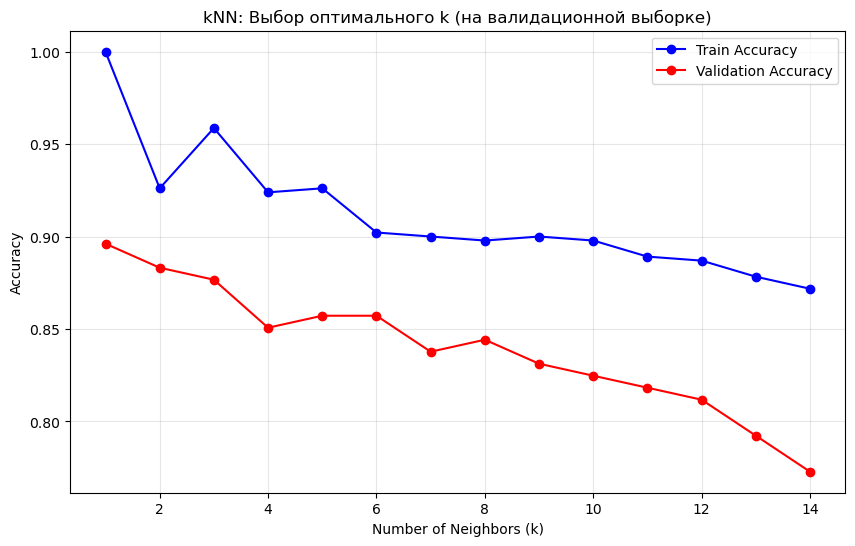

Оптимальное k (по валидационной выборке): 1


In [5]:
k_range = range(1, 15)
val_scores = []
train_scores = []

# Подбор k на валидационной выборке
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_score = knn.score(X_train_scaled, y_train)
    val_score = knn.score(X_val_scaled, y_val)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    print(f"k={k:2d}: Train Acc={train_score:.3f}, Val Acc={val_score:.3f}")

# Визуализация подбора k
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_scores, 'b-', label='Train Accuracy', marker='o')
plt.plot(k_range, val_scores, 'r-', label='Validation Accuracy', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('kNN: Выбор оптимального k (на валидационной выборке)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

optimal_k = k_range[np.argmax(val_scores)]
print(f"Оптимальное k (по валидационной выборке): {optimal_k}")

Оптимальное k = 1 может указывать на переобучение, поэтому возьмем следующий лучший k для обучения

In [6]:
if optimal_k == 1:
    second_best_idx = np.argsort(val_scores)[-2]
    optimal_k = k_range[second_best_idx]
    print(f"Используем k={optimal_k} для лучшего обобщения")

Используем k=2 для лучшего обобщения


In [7]:
# Финальное обучение на объединенных train + validation данных
X_final_train_knn = np.vstack([X_train_scaled, X_val_scaled])
y_final_train_knn = np.concatenate([y_train, y_val])

final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_final_train_knn, y_final_train_knn)

# Предсказания на тестовой выборке
y_pred_knn = final_knn.predict(X_test_scaled)
y_pred_proba_knn = final_knn.predict_proba(X_test_scaled)

In [8]:
# Метрики для kNN на тестовой выборке
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"\nМЕТРИКИ kNN (k={optimal_k}) на тестовой выборке:")
print(f"Accuracy:  {accuracy_knn:.3f}")
print(f"Precision: {precision_knn:.3f}")
print(f"Recall:    {recall_knn:.3f}")
print(f"F1-Score:  {f1_knn:.3f}")

print("\nОТЧЕТ КЛАССИФИКАЦИИ (kNN):")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))


МЕТРИКИ kNN (k=2) на тестовой выборке:
Accuracy:  0.870
Precision: 0.873
Recall:    0.870
F1-Score:  0.869

ОТЧЕТ КЛАССИФИКАЦИИ (kNN):
              precision    recall  f1-score   support

        High       0.83      0.96      0.89        46
         Low       0.89      0.91      0.90        45
      Medium       0.89      0.78      0.83        63

    accuracy                           0.87       154
   macro avg       0.87      0.88      0.87       154
weighted avg       0.87      0.87      0.87       154



Дерево решений

Depth= 1: Train Acc=0.593, Val Acc=0.597
Depth= 2: Train Acc=0.778, Val Acc=0.779
Depth= 3: Train Acc=0.878, Val Acc=0.812
Depth= 4: Train Acc=0.915, Val Acc=0.883
Depth= 5: Train Acc=0.935, Val Acc=0.890
Depth= 6: Train Acc=0.961, Val Acc=0.922
Depth= 7: Train Acc=0.965, Val Acc=0.942
Depth= 8: Train Acc=0.970, Val Acc=0.929
Depth= 9: Train Acc=0.976, Val Acc=0.929
Depth=10: Train Acc=0.989, Val Acc=0.929
Depth=11: Train Acc=0.996, Val Acc=0.929
Depth=12: Train Acc=1.000, Val Acc=0.929
Depth=13: Train Acc=1.000, Val Acc=0.929
Depth=14: Train Acc=1.000, Val Acc=0.929


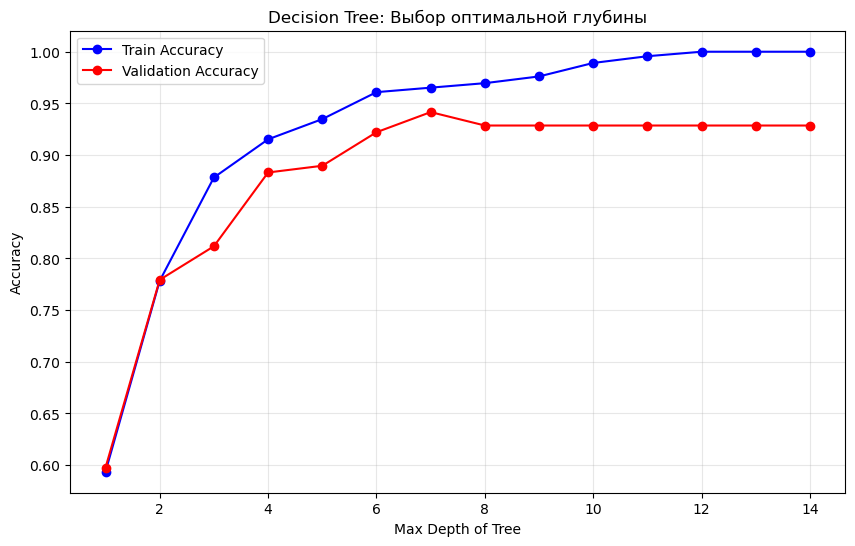

Оптимальная глубина: 7


In [9]:
# Подбор оптимальной глубины на валидационной выборке
depth_range = range(1, 15)
val_scores_tree = []
train_scores_tree = []

for depth in depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_score = tree.score(X_train, y_train)
    val_score = tree.score(X_val, y_val)
    
    train_scores_tree.append(train_score)
    val_scores_tree.append(val_score)
    print(f"Depth={depth:2d}: Train Acc={train_score:.3f}, Val Acc={val_score:.3f}")

# Визуализация подбора глубины
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_scores_tree, 'b-', label='Train Accuracy', marker='o')
plt.plot(depth_range, val_scores_tree, 'r-', label='Validation Accuracy', marker='o')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Выбор оптимальной глубины')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Выбираем оптимальную глубину по валидационной выборке
optimal_depth = depth_range[np.argmax(val_scores_tree)]
print(f"Оптимальная глубина: {optimal_depth}")

In [10]:
# Финальное обучение на объединенных данных
X_final_train_tree = pd.concat([X_train, X_val])
y_final_train_tree = np.concatenate([y_train, y_val])

final_tree = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
final_tree.fit(X_final_train_tree, y_final_train_tree)

# Предсказания на тестовой выборке
y_pred_tree = final_tree.predict(X_test)
y_pred_proba_tree = final_tree.predict_proba(X_test)

In [11]:
# Метрики для дерева решений на тестовой выборке
accuracy_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree, average='weighted')
recall_tree = recall_score(y_test, y_pred_tree, average='weighted')
f1_tree = f1_score(y_test, y_pred_tree, average='weighted')

print(f"\nМЕТРИКИ Decision Tree (depth={optimal_depth}) на тестовой выборке:")
print(f"Accuracy:  {accuracy_tree:.3f}")
print(f"Precision: {precision_tree:.3f}")
print(f"Recall:    {recall_tree:.3f}")
print(f"F1-Score:  {f1_tree:.3f}")

print("\nОТЧЕТ КЛАССИФИКАЦИИ (Decision Tree):")
print(classification_report(y_test, y_pred_tree, target_names=le.classes_))


МЕТРИКИ Decision Tree (depth=7) на тестовой выборке:
Accuracy:  0.922
Precision: 0.928
Recall:    0.922
F1-Score:  0.922

ОТЧЕТ КЛАССИФИКАЦИИ (Decision Tree):
              precision    recall  f1-score   support

        High       0.85      1.00      0.92        46
         Low       1.00      0.91      0.95        45
      Medium       0.93      0.87      0.90        63

    accuracy                           0.92       154
   macro avg       0.93      0.93      0.93       154
weighted avg       0.93      0.92      0.92       154



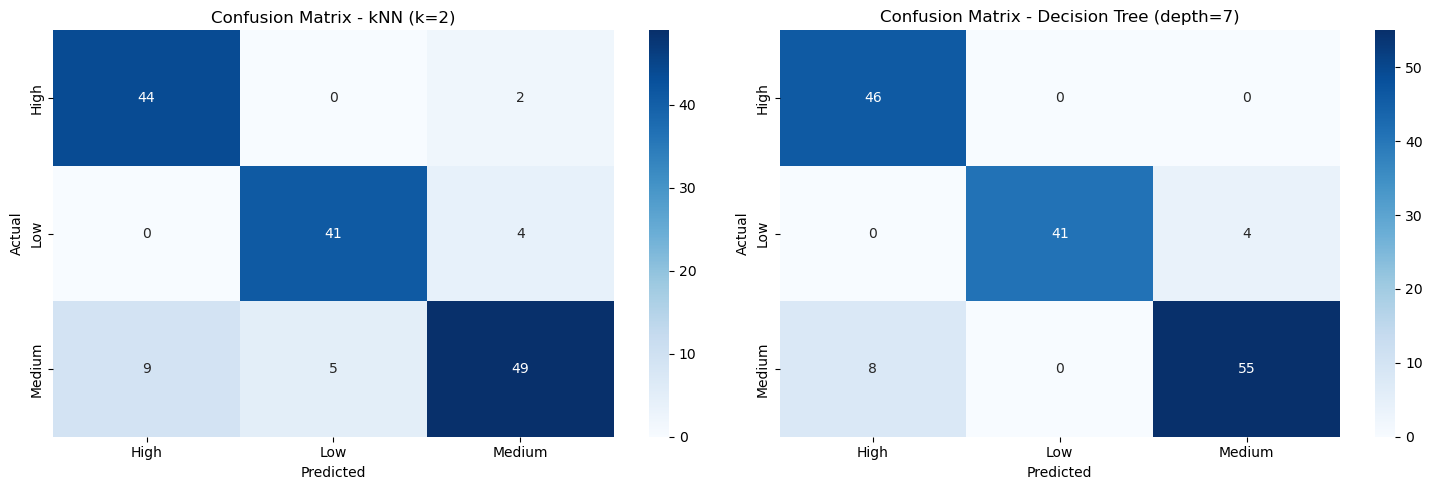

In [12]:
# Матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# kNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'Confusion Matrix - kNN (k={optimal_k})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Decision Tree
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'Confusion Matrix - Decision Tree (depth={optimal_depth})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

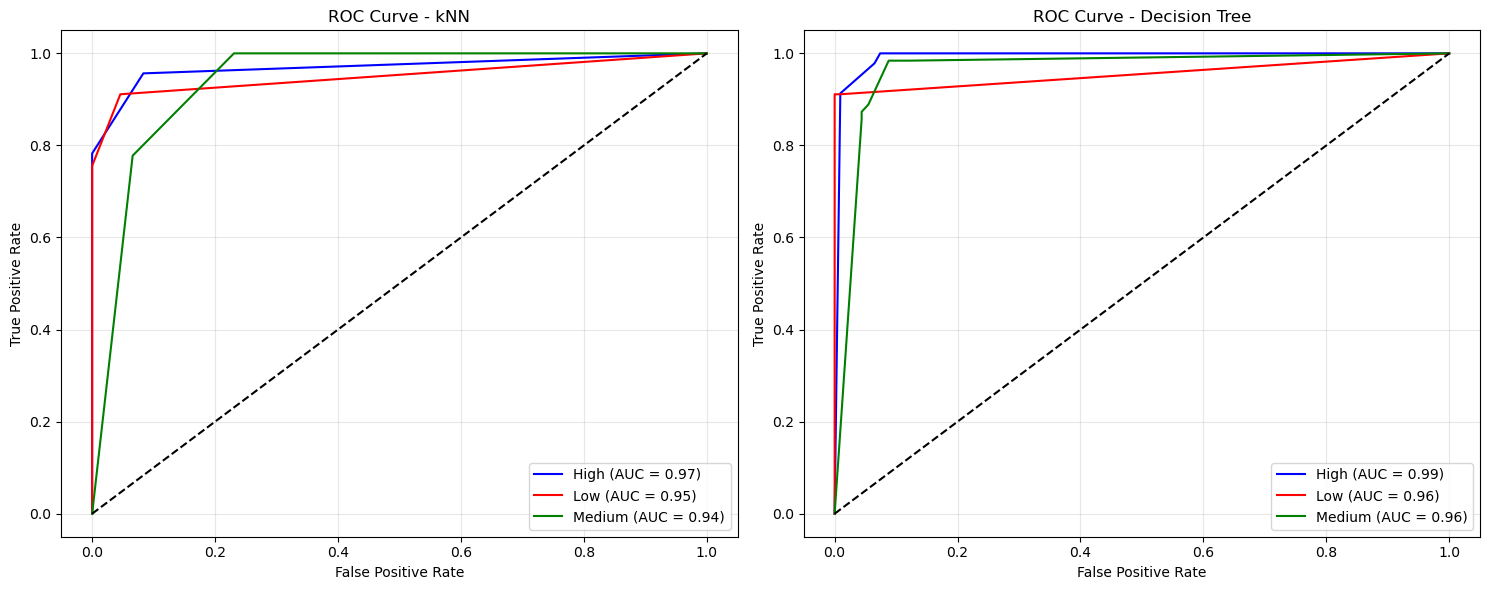

In [13]:
# ROC-кривые
from sklearn.preprocessing import label_binarize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# kNN ROC-кривые
fpr_knn, tpr_knn, roc_auc_knn = {}, {}, {}
for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Decision Tree ROC-кривые  
fpr_tree, tpr_tree, roc_auc_tree = {}, {}, {}
for i in range(n_classes):
    fpr_tree[i], tpr_tree[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_tree[:, i])
    roc_auc_tree[i] = auc(fpr_tree[i], tpr_tree[i])

# Графики
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    axes[0].plot(fpr_knn[i], tpr_knn[i], color=color, 
                label=f'{le.classes_[i]} (AUC = {roc_auc_knn[i]:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - kNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for i, color in zip(range(n_classes), colors):
    axes[1].plot(fpr_tree[i], tpr_tree[i], color=color, 
                label=f'{le.classes_[i]} (AUC = {roc_auc_tree[i]:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Decision Tree')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

РЕЗУЛЬТАТЫ  
МЕТРИКИ kNN (k=2) на тестовой выборке:
Accuracy:  0.870
Precision: 0.873
Recall:    0.870
F1-Score:  0.869  

МЕТРИКИ Decision Tree (depth=7) на тестовой выборке:
Accuracy:  0.922
Precision: 0.928
Recall:    0.922
F1-Score:  0.922

Из всех этих метрик и матрицы ошибок видно, что дерево решений чуть лучше справилось с задачей классификации, чем kNN, однако оба метода показали отличные результаты.  
Думаю, это объясняется тем, что данные не реальные, а имитационные. 